In [4]:
import pandas as pd
import numpy as np
import pathlib
from ast import literal_eval
import graph_tool as gt
from graph_tool.all import graph_draw
import graph_tool.topology as gtt


In [5]:
df = pd.read_csv("../../data/sample_data.csv")
df.drop(['message_id', 'milestone_index', 'datetime'], axis=1, inplace=True)

# df = pd.read_csv("../../data/first_14_days_UTXO_txs_of_IOTA.csv")
# df.drop(['message_id', 'milestone_index', 'datetime'], axis=1, inplace=True)

# df = pd.read_csv("../../data/chunk.csv")
# df.drop(['Unnamed: 0.1', 'Unnamed: 0', 'block_index', 'timestamp'], axis=1, inplace=True)


In [3]:
df_unique_tx_id = pd.DataFrame()
df_unique_tx_id['transaction_id'] = pd.unique(df[['transaction_id']].values.ravel())
df_unique_tx_id['tx_unique_id'] = df_unique_tx_id.index

pathlib.Path('../../logs/sample_logs').mkdir(parents=True, exist_ok=True)
df_unique_tx_id.to_csv('../../logs/sample_logs/generated_files/transaction_ids.csv', index=False)


OSError: Cannot save file into a non-existent directory: '../../logs/sample_logs/generated_files'

In [ ]:
df = df.merge(df_unique_tx_id, on='transaction_id', how='left')
df.drop(['transaction_id'], axis=1, inplace=True)

df = df[df['input_addresses_x'].str.contains("\[nan|nan,|, nan|nan]") == False]


In [ ]:
df


,input_addresses_x,input_amounts_x,output_addresses_y,output_amounts_y,tx_unique_id
0,['a1'],[100.0],"['a1', 'a2']","[99, 1]",0
1,['a1'],[100.0],"['a1', 'a2']","[99, 1]",1
2,['a1'],[100.0],"['a1', 'a2']","[99, 1]",2
3,['a3'],[680.0],"['a4', 'a5']","[600, 80]",3
4,['a6'],[100.0],['a7'],[100],4
5,"['a2', 'a3', 'a2', 'a2', 'a2', 'a2', 'a2', 'a2...","[1.0, 541.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","['a2', 'a2']","[1, 549]",5
6,['a1'],[100.0],"['a1', 'a2']","[99, 1]",6
7,['a8'],[100.0],"['a9', 'a10']","[50, 50]",7
8,['a11'],[650.0],"['a12', 'a13']","[20, 630]",8
9,['a14'],[100.0],['a15'],[100],9


In [ ]:
graph_of_correspondences = gt.Graph( directed=False )
nodes_dict = {}

# Setting properties of graph
vertex_property = graph_of_correspondences.new_vertex_property("string")
edge_property = graph_of_correspondences.new_edge_property("object")



In [ ]:
def add_correspondence(row, graph_of_correspondences, ip_addrs_idx, op_addrs_idx, ip_amt_idx, op_amt_idx):

    nodes_list = literal_eval(row[ip_addrs_idx]) # converts string to list form

    ip_amt = literal_eval(row[ip_amt_idx])
    op_amt = literal_eval(row[op_amt_idx])
    op_addrs = literal_eval(row[op_addrs_idx])
    h1 = 0
    
    # h1 - get change address
    if min(op_amt) < min(ip_amt): 
        idx = np.argmin(op_amt)
        change_addrs = op_addrs[idx]
        nodes_list.append(change_addrs)
        h1 = 1

    nodes_list = set(nodes_list)

    if len(nodes_list) <= 1: return

    for node in nodes_list :
        if node in nodes_dict: continue
        vertex = graph_of_correspondences.add_vertex()
        idx = graph_of_correspondences.vertex_index[vertex]
        nodes_dict[node] = idx
        vertex_property[vertex] = node

    v0 = nodes_dict[nodes_list.pop()]

    for node in nodes_list:
        v1 = nodes_dict[node]
        if not graph_of_correspondences.edge(v0,v1):
            e = graph_of_correspondences.add_edge(v0,v1)
            edge_property[e] = {'node1': v0, 'node2': v1, "h0": 1, "h1": h1, "count_of_same_edge": 1}
        else: 
            e = graph_of_correspondences.edge(v0,v1)
            edge_property[e]['count_of_same_edge'] += 1  
    return



In [ ]:
def compute_components(graph_of_correspondences):
    comp_list = []
    components = {}
    comps, _ = gtt.label_components(graph_of_correspondences)

    for i in range(graph_of_correspondences.num_vertices()):
        c = comps[i]
        if c not in components: components[c] = [i]
        else: components[c].append(i)

    for c in components:
        comp_list.append({'component' : c, 'address_ids' : components[c]})

    return comp_list



In [ ]:
df.apply(
            add_correspondence, 
            graph_of_correspondences=graph_of_correspondences, 
            ip_addrs_idx = 0, 
            op_addrs_idx = 2, 
            ip_amt_idx = 1, 
            op_amt_idx = 3,
            axis=1
        )

components = compute_components(graph_of_correspondences)


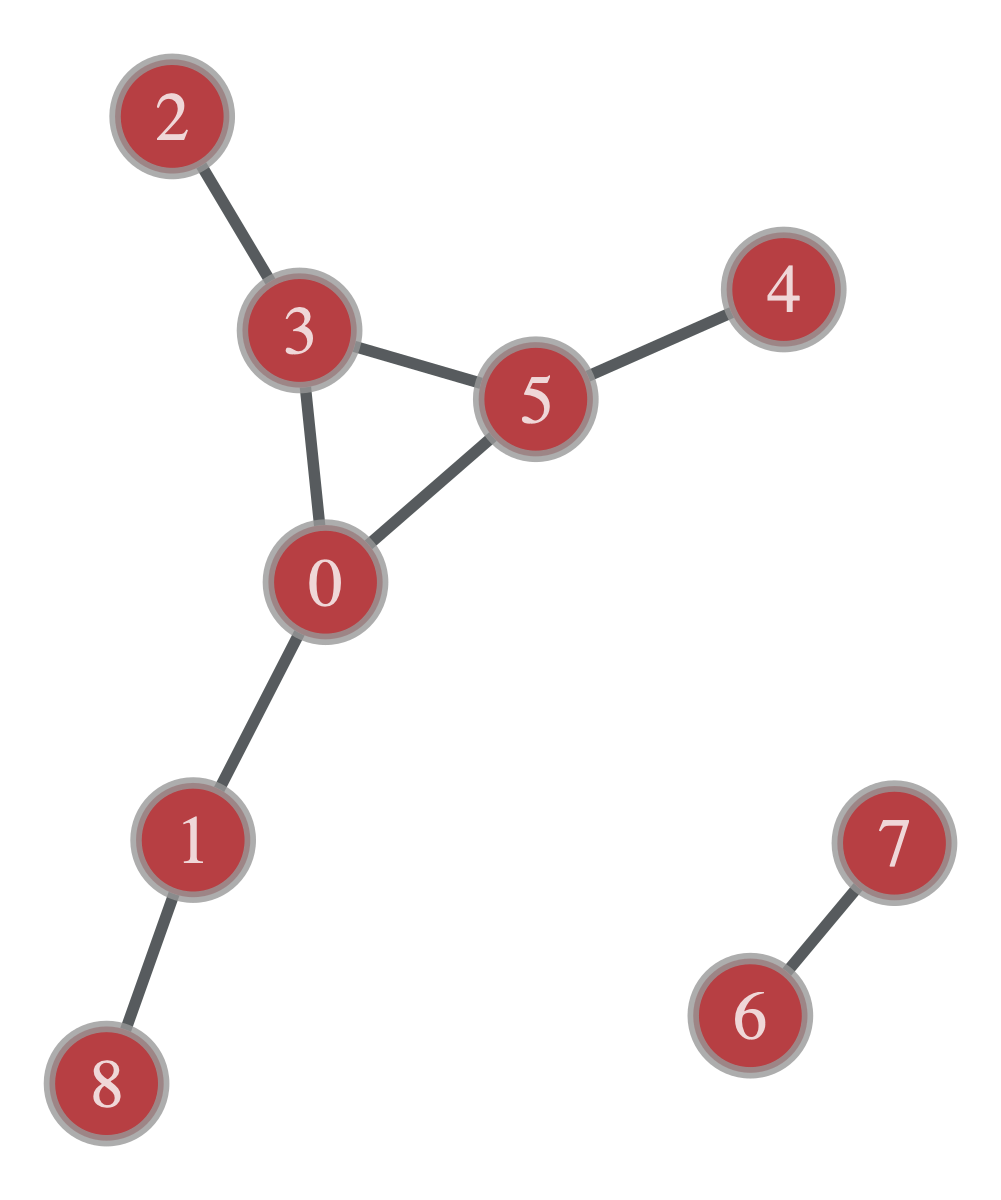

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x28d25e7f0, at 0x28d2595b0>

In [ ]:
from graph_tool import draw
draw.graph_draw(graph_of_correspondences, vertex_text=graph_of_correspondences.vertex_index)


In [ ]:
vertices_mapping = []
for i in range(graph_of_correspondences.num_vertices()):
    vertices_mapping.append({'address' : vertex_property[i], 'address_id' : i})
df = pd.DataFrame.from_dict(vertices_mapping, orient='columns')
df.to_csv('../../logs/sample_logs/generated_files/address_ids.csv', index=False)

edge_mapping = []
for e in graph_of_correspondences.edges(): 
    edge_mapping.append(edge_property[e])
df = pd.DataFrame.from_dict(edge_mapping, orient='columns')
df.to_csv('../../logs/sample_logs/generated_files/edge_data.csv', index=False)


In [ ]:
print('\nComponent:vertices mapping \n', components)
df = pd.DataFrame.from_dict(components, orient='columns')
df.to_csv('../../logs/sample_logs/generated_files/components.csv', index=False)



Component:vertices mapping 
 [{'component': 0, 'address_ids': [0, 1, 2, 3, 4, 5, 8]}, {'component': 1, 'address_ids': [6, 7]}]


In [2]:
import matplotlib.pyplot as plt

# Function to plot bar graph  given a dataframe
def plot_bar_or_line_graph_long(df, graph_type, ylabel, xlabel, title, colour, log_scale, rotation):
    plt.figure(figsize=(12,5))
    if graph_type == 'bar':
        plot_bar = plt.bar(df.index, df, color=colour)
        plt.bar_label(plot_bar)
    elif graph_type == 'line':
        plot_bar = plt.plot(df.index, df, color=colour)
    if log_scale == 'y':
        plt.yscale('log')
    elif log_scale == 'x':
        plt.xscale('log')
    plt.ylabel(ylabel, size = 14)
    plt.xlabel(xlabel, size = 14)
    # plt.xticks(df.index, rotation = rotation)
    plt.title(title, size = 16)
    plt.show()
    
    return plt
    

# Function to plot bar graph  given a dataframe
def plot_bar_or_line_graph(df, ylabel, xlabel, title, log_scale):
    plt.figure(figsize=(12,5))
    plot_bar = plt.bar(df.index, df)
    # plt.bar_label(plot_bar)
    if log_scale == 'y':
        plt.yscale('log')
    elif log_scale == 'x':
        plt.xscale('log')
    plt.ylabel(ylabel, size = 14)
    plt.xlabel(xlabel, size = 14)
    plt.title(title, size = 16)
    plt.show()
    
    return plt


$$$$$$$$$$$$$$$$$h0$$$$$$$$$$$$$$$$$


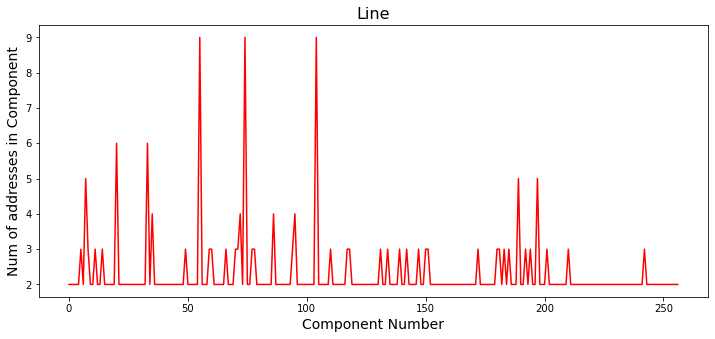

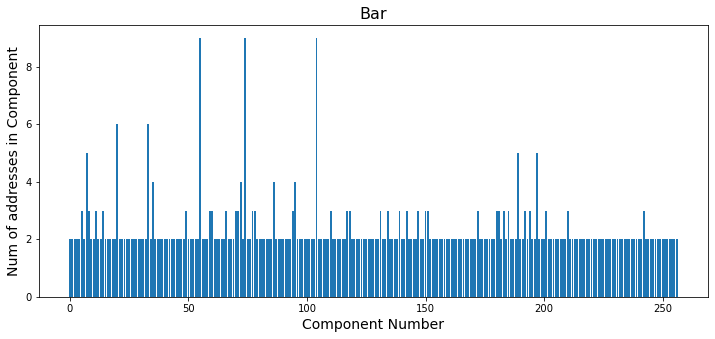

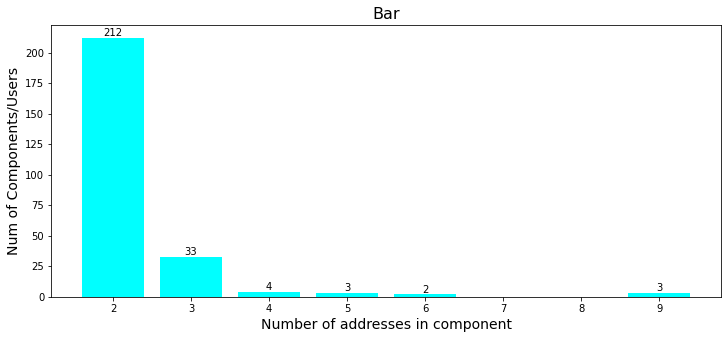

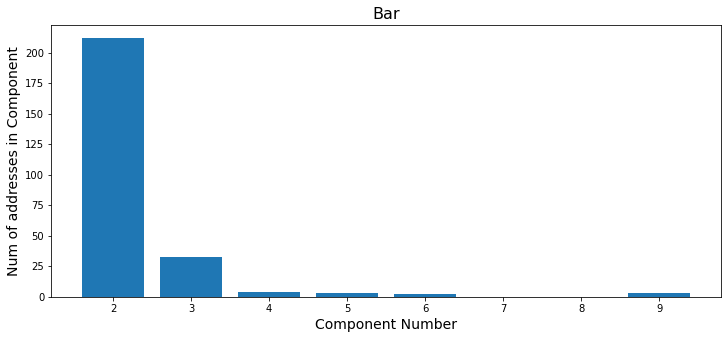

$$$$$$$$$$$$$$$$$h0+h1$$$$$$$$$$$$$$$$$


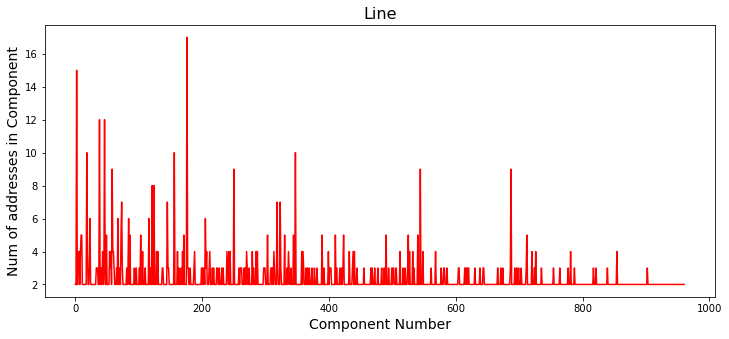

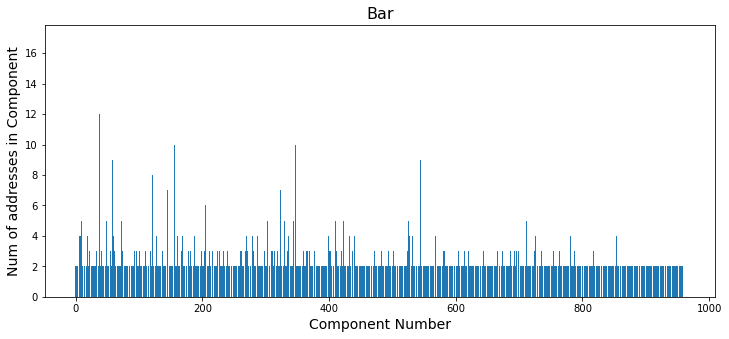

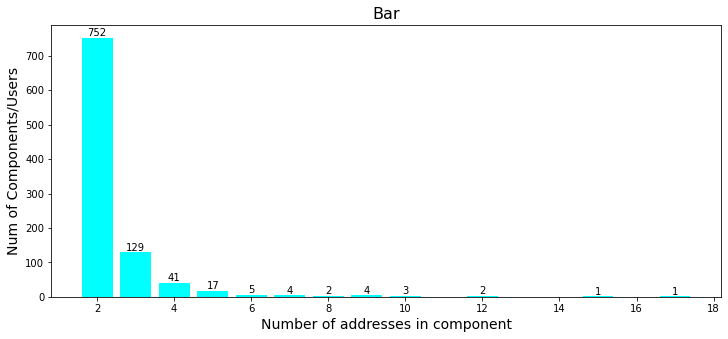

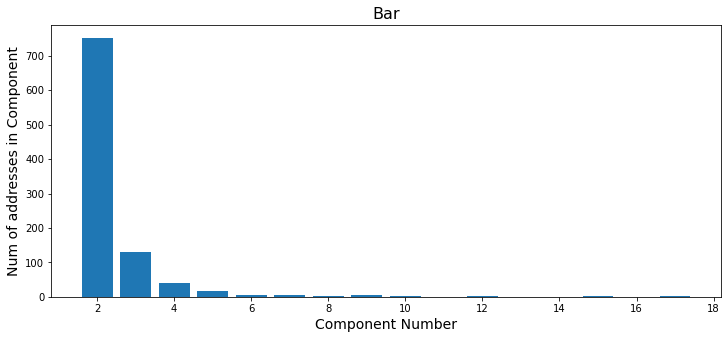

In [3]:
import pandas as pd
for h in ['h0', 'h0+h1']:
    print('$$$$$$$$$$$$$$$$$' + h + '$$$$$$$$$$$$$$$$$')
    df = pd.read_csv('../../logs/IoTa_logs/'+ h + '/generated_files/components.csv')
    plot_bar_or_line_graph_long(df['num_of_addrs'], 'line', 'Num of addresses in Component', 
                        'Component Number', 'Line', 'red', 'log', 0)
    plot_bar_or_line_graph(df['num_of_addrs'], 'Num of addresses in Component', 
                            'Component Number', 'Bar', 'log')
    df_plot = df.groupby(['num_of_addrs']).size()

    plot_bar_or_line_graph_long(df_plot, 'bar', 'Num of Components/Users', 
                            'Number of addresses in component', 'Bar', 'cyan', 'log', 0)
    plot_bar_or_line_graph(df_plot, 'Num of addresses in Component', 
                            'Component Number', 'Bar', 'log')



In [48]:
def prob_dist_plot(data):
    plt.figure(figsize=(12,5))
    hist = plt.hist(data, bins=max(data), histtype ='bar', density = True)
    plt.bar(range(len(max(data))-1),h, width=1, edgecolor='k')
    print(hist)
    for bar in hist:
        print('##########')
        print(bar)
        # plt.annotate(bar.get_height())
    plt.ylim(0,1)
    plt.xlabel('Num of addresses n', size = 14)
    plt.ylabel('Probability a component will have num of addresses n', size = 14)
    plt.title("Distribution", size = 16)




(array([1.06058922, 0.16509172, 0.02001112, 0.01500834, 0.        ,
       0.01000556, 0.        , 0.        , 0.01500834]), array([2.        , 2.77777778, 3.55555556, 4.33333333, 5.11111111,
       5.88888889, 6.66666667, 7.44444444, 8.22222222, 9.        ]), <BarContainer object of 9 artists>)
##########
[1.06058922 0.16509172 0.02001112 0.01500834 0.         0.01000556
 0.         0.         0.01500834]
##########
[2.         2.77777778 3.55555556 4.33333333 5.11111111 5.88888889
 6.66666667 7.44444444 8.22222222 9.        ]
##########
<BarContainer object of 9 artists>


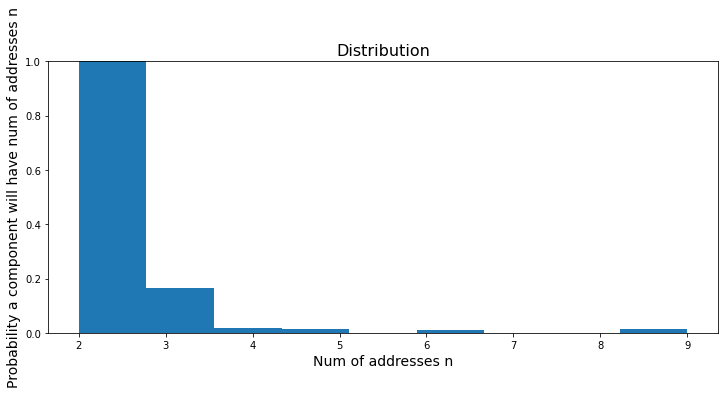

In [49]:
df = pd.read_csv('../../logs/IoTa_logs/h0/generated_files/components.csv')
prob_dist_plot(df['num_of_addrs'])
